In [2]:
# !apt-get update
# !apt-get install g++ openjdk-8-jdk
# !pip install konlpy JPype1-py3

In [3]:
# %%bash
# apt-get update
# apt-get install g++ openjdk-8-jdk python-dev python3-dev
# pip3 install JPype1
# pip3 install konlpy

In [4]:
# %env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

> **한글 NLP 처리의 어려움**

- 띄어쓰기 & 다양한 조사

- 영어의 경우 띄어쓰기를 잘못하면 잘못된 단어로 분석에서 제외가 되는데, 한글은 띄어쓰기를 잘못하면 다른 단어로 인식됨
- 조사는 워낙 경우의 수가 많아, 어근 추출 등의 전처리 시 제거가 까다로움
- ex) 너희 집은 어디 있니? <-> 집 은 (house, silver)
- ex) 집은, 집이, 집도, 집에서, 집에...

> ### **konlpy**

- 형태소 : 의미를 가지는 최소 단위
- 형태소 분석 : 말뭉치를 이러한 형태소 어근 단위로 쪼개고 각 형태소에 품사 태깅을 부착하는 작업

> - [한글 형태소 분석](https://iostream.tistory.com/144?utm_source=gaerae.com&utm_campaign=%EA%B0%9C%EB%B0%9C%EC%9E%90%EC%8A%A4%EB%9F%BD%EB%8B%A4&utm_medium=social)

> mecab

- https://colab.research.google.com/drive/1IHqCicmaDHIJtpywlGFYD9wS-zQ-J-s3?usp=sharing
- https://pypi.org/project/python-mecab-ko/

> Okt : Twitter => Okt로 바뀜

```python
from konlpy.tag import Okt
translate = Okt()
```



In [5]:
! pip install konlpy

In [6]:
import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from konlpy.utils import pprint
from konlpy.tag import Mecab

### **Data Loading**

[네이버 영화 평점 데이터](https://github.com/e9t/nsmc)

In [7]:
import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/Kaggle - 파이썬 머신러닝 완벽 가이드/kaggleData/ratings_train.txt', sep = '\t',  encoding='UTF8')
train_df.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


train_data의 0과 1의 Label 값 비율

- 1이 긍정
- 0이 부정

In [8]:
train_df['label'].value_counts()
# 0, 1이 균등한 분포

0    75173
1    74827
Name: label, dtype: int64

- 문자가 아닌 숫자의 경우, 의미가 부족하기에 공백으로  변환
- 숫자를 공백으로 변환하는 것은 텍스트의 일관성을 유지하면서 텍스트의 길이를 줄일 수 있습니다. 이는 특히 텍스트의 토큰화나 벡터화 단계에서 유용합니다. 또한, 숫자를 제거하거나 변환함으로써 텍스트의 노이즈를 줄이고 모델의 성능을 향상시킬 수 있습니다.

> **re.sub(r"\d+", ' ', x)**

- sub() 함수는 주어진 패턴에 일치하는 부분을 지정된 대체 문자열로 대체하는 역할

- r"\d+": 하나 이상의 숫자

- ' ': 대체할 문자열

- x: 대상 문자열



In [9]:
train_df['document'].isnull().sum()

5

In [10]:
train_df['document'].head()

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
Name: document, dtype: object

In [11]:
import re

train_df = train_df.fillna(' ')
# 정규 표현식을 이용하여 숫자를 공백으로 변경(정규 표현식으로 \d 는 숫자를 의미함.)
train_df['document'] = train_df['document'].apply(lambda x : re.sub(r"\d+", ' ', x))

# 테스트 데이터 셋을 로딩하고 동일하게 Null 및 숫자를 공백으로 변환
test_df = pd.read_csv('/content/drive/MyDrive/Kaggle - 파이썬 머신러닝 완벽 가이드/kaggleData/ratings_test.txt', sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply( lambda x : re.sub(r"\d+", " ", x) )

# id 칼럼 삭제 수행
train_df.drop('id', axis = 1, inplace = True)
test_df.drop('id', axis = 1, inplace = True)

### **토큰화**
- 문장을 한글 형태소 분석을 통해 형태소 단어로 토큰화
- 한글 형태소 엔진은 SNS 분석에 적합한 Okt 클래스 이용
- Okt 객체의 morphs() 메서드를 이용하면 문장을 형태소 단어로 토큰화해 list 객체 반환
- Tfidf 피처 벡터화의 tokenizer로 사용을 위해 토큰화 작업을 tw_tokenizer() 함수로 생성

In [12]:
# 문장을 형태소 단어 형태로 반환하는 tokenizer 함수
import konlpy
from konlpy.tag import Twitter

twitter = Twitter()
def tw_tokenizer(text):
    # morphs() : 입력 인자로 들어온 text를 형태소 단어로 토큰화 하여 list 객체 반환
    tokens_ko = twitter.morphs(text)
    return tokens_ko

/usr/local/lib/python3.10/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


> TfidfVectorizer(tokenizer=twitter.morphs()) 와 같이 메서드를 tokenizer 매개변수에 전달하면 에러가 발생한다.

- tokenizer 매개변수는 텍스트를 토큰화하는 함수를 기대합니다. 그러나 twitter.morphs()는 함수가 아니라 메서드입니다. 이 메서드를 바로 전달할 수 없으며, 대신에 해당 메서드를 호출하여 반환된 값을 전달해야 합니다.


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs( ) 객체를 이용한 tokenizer를 사용. ngram_range는 (1,2)
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### **로지스틱 회귀를 이용해 분류 기반의 감성 분석 수행**

- 정규화(regularization) 강도를 조절하는 매개변수
- C의 값이 클수록 모델이 훈련 데이터에 대해 덜 규제되고, C의 값이 작을수록 모델이 더 많이 규제
- 일반적으로 C의 값이 작을수록 규제 강도가 강해지므로 모델이 더 많이 규제됩니다. 이는 모델이 간단해지고 과적합을 방지할 수 있습니다. 반대로 C의 값이 클수록 규제 강도가 약해지므로 모델이 덜 규제되며, 훈련 데이터에 더 맞춰져 과적합될 가능성이 있습니다.

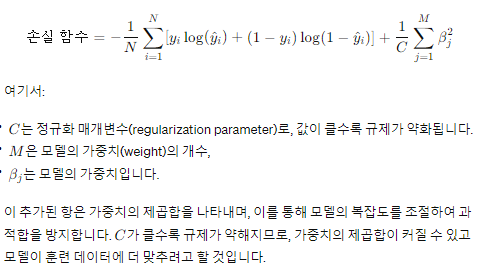

In [15]:
# Logistic Regression 을 이용하여 감성 분석 Classification 수행.
lg_clf = LogisticRegression(random_state=0, solver='liblinear')

# Parameter C 최적화를 위해 GridSearchCV 를 이용.
params = { 'C': [1 ,3.5, 4.5, 5.5, 10 ] }
grid_cv = GridSearchCV(lg_clf, param_grid = params, cv = 3, scoring = 'accuracy', verbose = 1)
grid_cv.fit(tfidf_matrix_train, train_df['label'])
print(grid_cv.best_params_, round(grid_cv.best_score_,4))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'C': 3.5} 0.8593


In [17]:
from sklearn.metrics import accuracy_score

# 학습 data로 학습한 TfidfVectorizer를 이용해 test data를 tf-idf 값으로 피처 변환
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

# classifier 는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_

In [18]:
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도: ',accuracy_score(test_df['label'],preds))

Logistic Regression 정확도:  0.86172


> TF-IDF 기반의 분석과 코사인 유사도 기반의 분석은 주로 다음과 같이 함께 활용된다

1. **TF-IDF 기반의 벡터화**: 먼저 TF-IDF 기반의 벡터화를 사용하여 각 문서를 벡터 형태로 표현합니다. 이를 통해 각 문서의 단어들을 가중치를 부여하여 표현하게 됩니다. 이 단계에서는 각 문서의 특징을 추출하고 벡터화합니다.

2. **코사인 유사도 계산**: 벡터화된 각 문서에 대해 코사인 유사도를 계산합니다. 이는 문서 간의 유사성을 측정하는 데 사용됩니다. 코사인 유사도는 각 문서 벡터 간의 각도를 계산하여 유사성을 측정하므로, 이를 통해 문서 간의 상대적인 유사성을 알 수 있습니다.

- 이처럼 TF-IDF 기반의 벡터화와 코사인 유사도 계산은 보통 순차적으로 진행됩니다. 먼저 TF-IDF를 사용하여 각 문서를 벡터화하고, 이후에는 벡터화된 문서 간의 코사인 유사도를 계산합니다. 이렇게 함으로써 문서 간의 유사성을 정량화하고, 유사한 문서를 찾거나 분류하는 데 활용할 수 있습니다.